### INA Project - Passing influence on a football game outcome

Project for Course INA: (Introduction to) Network Analysis at UL FRI 2022/2023

Students:
* Aleksandar Georgiev
* Luka Pavićević
* Dragan Majkić

In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# StatsBombPy
from statsbombpy import sb

# For Pitch
from mplsoccer.pitch import Pitch

# Disable Warnings for statsbombpy and No Auth Warning
import warnings
warnings.filterwarnings("ignore")

# Load helper functions
from helper_functions import plot_passes_for_player, get_players_names, get_match_passes_by_team, create_graph

# Networkx
import networkx as nx

In [2]:
# Install statsbombpy and mplsoccer libraries

#!pip install statsbombpy
#!pip install mplsoccer
#!pip install networkx

#### Data Preparation

In [3]:
# Available FIFA World Cup competitions

comp = sb.competitions()
world_cup_comp = comp[comp['competition_name'] == 'FIFA World Cup']
world_cup_comp

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
18,43,106,International,FIFA World Cup,male,False,True,2022,2023-05-13T12:22:12.754153,2023-05-17T14:47:15.231375,2023-05-17T14:47:15.231375,2023-05-13T12:22:12.754153
19,43,3,International,FIFA World Cup,male,False,True,2018,2022-09-05T17:17:56.670896,2021-06-13T16:17:31.694,None,2022-09-05T17:17:56.670896


In [4]:
# Find all matches in that competition

matches = sb.matches(competition_id=43, season_id=106)
matches_ids = matches['match_id'].to_list()

# Show matches
# matches[matches['competition_stage'] == 'Final']
matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3857256,2022-12-02,21:00:00.000,International - FIFA World Cup,2022,Serbia,Switzerland,2,3,available,...,2023-04-26T23:49:58.956186,3,Group Stage,Stadium 974,Fernando Andrés Rapallini,Dragan Stojković,Murat Yakin,1.1.0,2,2
1,3869151,2022-12-03,21:00:00.000,International - FIFA World Cup,2022,Argentina,Australia,2,1,available,...,2023-05-14T23:35:15.370647,4,Round of 16,Ahmad bin Ali Stadium,Szymon Marciniak,Lionel Sebastián Scaloni,Graham James Arnold,1.1.0,2,2
2,3857257,2022-11-30,17:00:00.000,International - FIFA World Cup,2022,Australia,Denmark,1,0,available,...,2023-04-28T17:16:11.332325,3,Group Stage,Al Janoub Stadium,Mustapha Ghorbal,Graham James Arnold,Kasper Hjulmand,1.1.0,2,2
3,3857258,2022-11-24,21:00:00.000,International - FIFA World Cup,2022,Brazil,Serbia,2,0,available,...,2023-04-27T00:37:37.774814,1,Group Stage,Lusail Stadium,Alireza Faghani,Telê Santana da Silva,Dragan Stojković,1.1.0,2,2
4,3857288,2022-11-26,12:00:00.000,International - FIFA World Cup,2022,Tunisia,Australia,0,1,available,...,2023-04-27T00:30:07.835815,2,Group Stage,Al Janoub Stadium,Daniel Siebert,Jalel Kadri,Graham James Arnold,1.1.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,3857265,2022-11-22,18:00:00.000,International - FIFA World Cup,2022,Mexico,Poland,0,0,available,...,2023-04-27T00:49:30.005344,1,Group Stage,Stadium 974,Chris Beath,Gerardo Daniel Martino,Czesław Michniewicz,1.1.0,2,2
60,3857262,2022-12-02,17:00:00.000,International - FIFA World Cup,2022,South Korea,Portugal,2,1,available,...,2023-04-26T23:48:08.999798,3,Group Stage,Education City Stadium,Facundo Tello Figueroa,Paulo Jorge Gomes Bento,Fernando Manuel Fernandes da Costa Santos,1.1.0,2,2
61,3857261,2022-11-29,21:00:00.000,International - FIFA World Cup,2022,Wales,England,0,3,available,...,2023-04-27T00:02:44.241621,3,Group Stage,Ahmad bin Ali Stadium,Slavko Vinčić,Robert Page,Gareth Southgate,1.1.0,2,2
62,3857255,2022-12-01,21:00:00.000,International - FIFA World Cup,2022,Japan,Spain,2,1,available,...,2023-04-26T23:51:48.352990,3,Group Stage,Sheikh Khalifa International Stadium,Victor Miguel de Freitas Gomes,Hajime Moriyasu,Luis Enrique Martínez García,1.1.0,2,2


In [5]:
# Find matches and extract informations about passes

# Id 9 is Final match between Argentina and France
match_id = matches_ids[9]
match_events = sb.events(match_id=match_id)

team1_goals, team2_goals = int(matches[matches['match_id'] == match_id]['home_score']), int(matches[matches['match_id'] == match_id]['away_score'])
team1, team2 = matches[matches['match_id'] == match_id]['home_team'].values[0], matches[matches['match_id'] == match_id]['away_team'].values[0]

# We need only passing data
match_passes = match_events[['team', 'type', 'minute', 'second', 'location', 'pass_end_location', 'pass_outcome', 'player']]

#### Passes Plots

Team 1 - Argentina - players 26: {'Ángel Fabián Di María Hernández': 11, 'Nicolás Hernán Otamendi': 19, 'Lionel Andrés Messi Cuccittini': 10, 'Nicolás Alejandro Tagliafico': 3, 'Paulo Bruno Exequiel Dybala': 21, 'Franco Armani': 1, 'Ángel Martín Correa': 15, 'Gerónimo Rulli': 12, 'Damián Emiliano Martínez': 23, 'Alejandro Darío Gómez': 17, 'Germán Alejandro Pezzella': 6, 'Rodrigo Javier De Paul': 7, 'Lautaro Javier Martínez': 22, 'Leandro Daniel Paredes': 5, 'Marcos Javier Acuña': 8, 'Cristian Gabriel Romero': 13, 'Juan Marcos Foyth': 2, 'Guido Rodríguez': 18, 'Lisandro Martínez': 25, 'Alexis Mac Allister': 20, 'Gonzalo Ariel Montiel': 4, 'Exequiel Alejandro Palacios': 14, 'Thiago Ezequiel Almada': 16, 'Nahuel Molina Lucero': 26, 'Julián Álvarez': 9, 'Enzo Fernandez': 24}


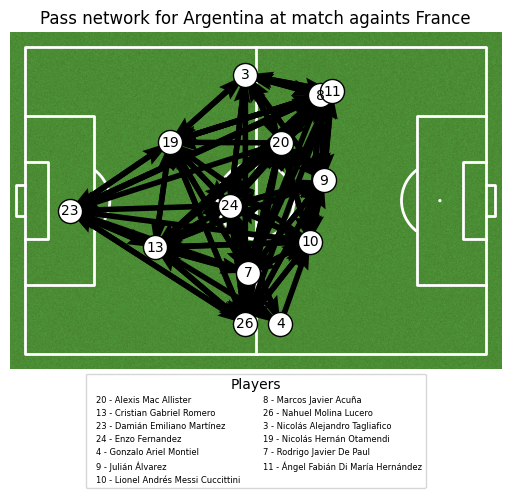

In [6]:
# One match - Show team with Legend

players = get_players_names(match_id, team1)
print(f'Team 1 - {team1} - players {len(players)}: {players}')

passes_team1_match = get_match_passes_by_team(match_passes, team1, players, team2, team_position = 0, show_legend=True, show_pitch=True)

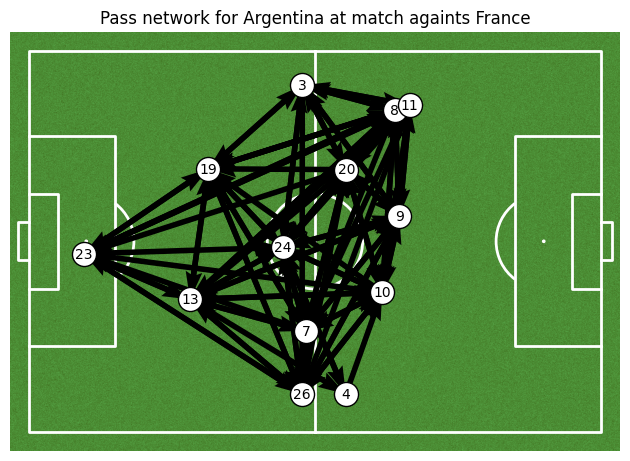

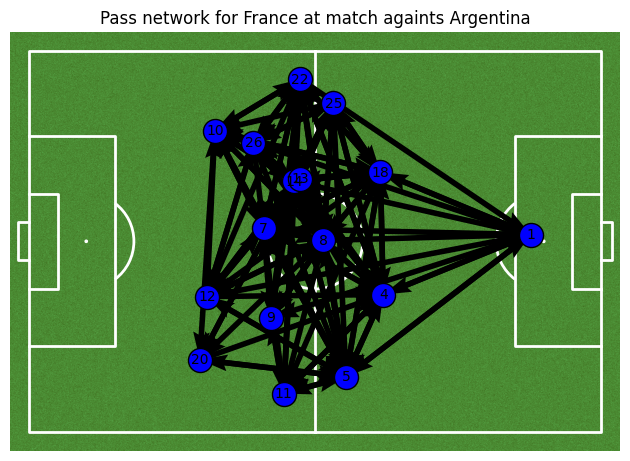

In [7]:
# One match - Both teams

# First team
players = get_players_names(match_id, team1)
passes_team1_match = get_match_passes_by_team(match_passes, team1, players, team2, team_position = 0, show_pitch=True)

# Second team
players = get_players_names(match_id, team2)
passes_team1_match = get_match_passes_by_team(match_passes, team2, players, team1, team_position = 1, show_pitch=True)

Passes for player: Lionel Andrés Messi Cuccittini
Different passes: [nan 'Incomplete' 'Pass Offside']
pass_outcome
Successful      81.666667
Incomplete      16.666667
Pass Offside     1.666667
Name: proportion, dtype: float64


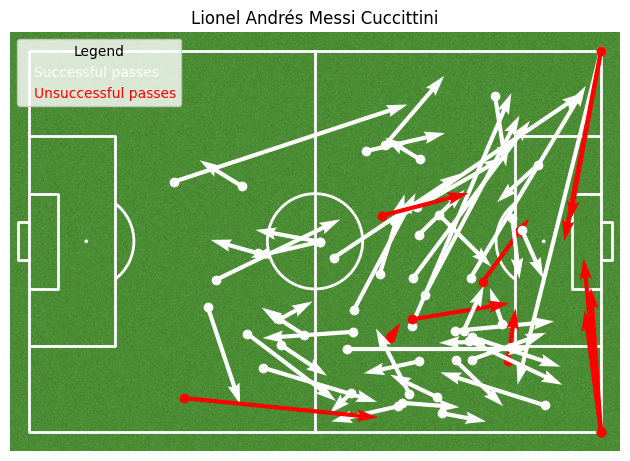

In [8]:
# Show passes for one player on one match

plot_passes_for_player(match=match_passes, player='Lionel Andrés Messi Cuccittini')

#### Networkx analysis - Graphs

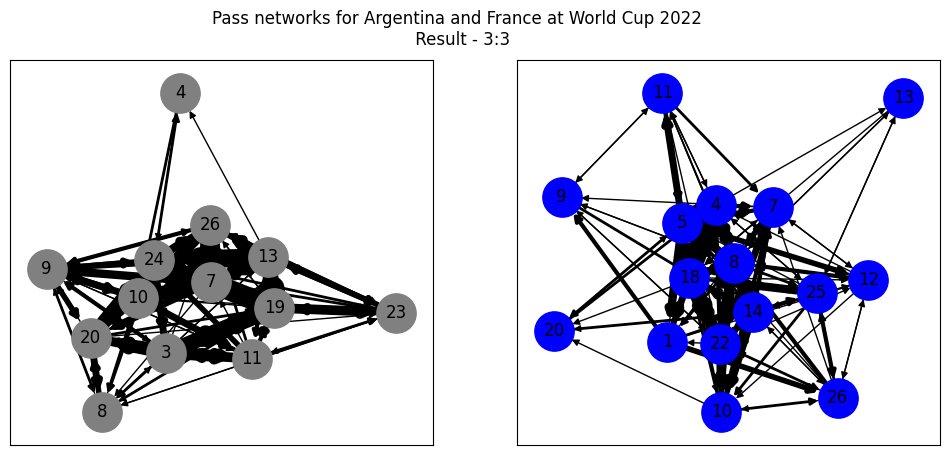

In [9]:
# One Match - Graphs

# Team 1
players_team1 = get_players_names(match_id, team1)
passes_team1_match = get_match_passes_by_team(match_passes, team1, players_team1, team2, team_position = 0, show_pitch=False)

# Team 2
players_team2 = get_players_names(match_id, team2)
passes_team2_match = get_match_passes_by_team(match_passes, team2, players_team2, team1, team_position = 1, show_pitch=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Get Graph for Team 1 at One Match
G_team1_match = create_graph(passes_team1_match)

edges = G_team1_match.edges()
weights = [G_team1_match[u][v]['weight'] for u, v in edges]

# Plot Graph
nx.draw_networkx(G_team1_match, node_size=800, with_labels=True, node_color='gray', width = weights, ax=ax1)

# ----------------------------------------------------------------------------------------------------

# Get Graph for Team 2 at One Match
G_team2_match = create_graph(passes_team2_match)

edges = G_team2_match.edges()
weights = [G_team2_match[u][v]['weight'] for u, v in edges]

# Plot Graph
nx.draw_networkx(G_team2_match, node_size=800, with_labels=True, node_color='blue', width = weights, ax=ax2)

plt.suptitle(f"Pass networks for {team1} and {team2} at World Cup 2022 \n Result - {team1_goals}:{team2_goals}")
plt.show()

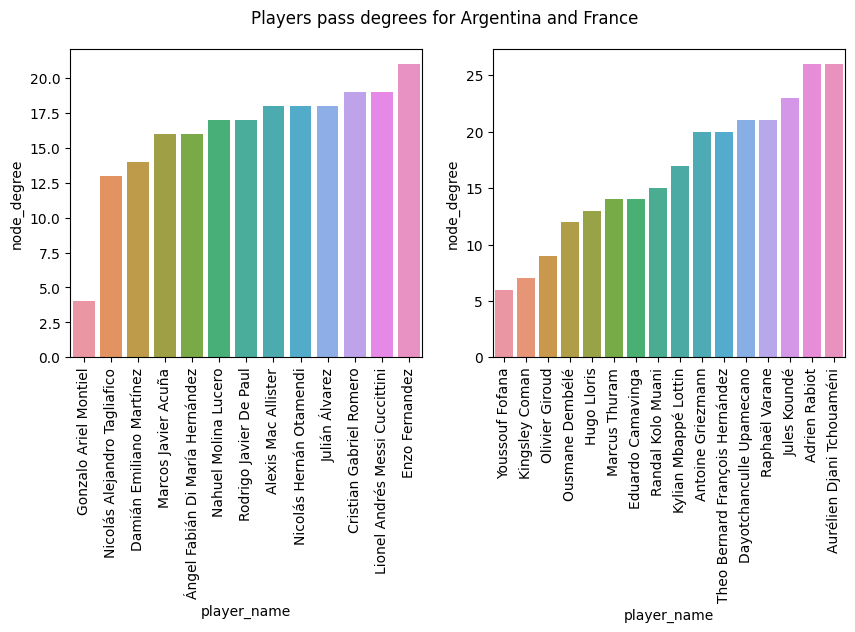

In [10]:
# Networkx analysis for G_team1_match and G_team2_match

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Node degree - Team 1
degrees_team1 = dict(nx.degree(G_team1_match))
degrees_df_team1 = pd.DataFrame.from_dict(list(degrees_team1.items()))
degrees_df_team1.rename(columns = {0:'jersey_number', 1: 'node_degree'}, inplace = True)

# Get Player name instead of Jersey number
team1_players_df = sb.lineups(match_id=match_id)[team1]
degrees_df_team1 = pd.merge(degrees_df_team1, team1_players_df, on='jersey_number', how='left')

degrees_df_team1 = degrees_df_team1.sort_values(by=['node_degree'])

sns.barplot(degrees_df_team1, x='player_name', y='node_degree', order=degrees_df_team1.sort_values('node_degree').player_name, ax=ax1)
ax1.set_xticklabels(degrees_df_team1['player_name'], rotation=90)

# Node degree - Team 2
degrees_team2 = dict(nx.degree(G_team2_match))
degrees_df_team2 = pd.DataFrame.from_dict(list(degrees_team2.items()))
degrees_df_team2.rename(columns = {0:'jersey_number', 1: 'node_degree'}, inplace = True)

# Get Player name instead of Jersey number
team2_players_df = sb.lineups(match_id=match_id)[team2]
degrees_df_team2 = pd.merge(degrees_df_team2, team2_players_df, on='jersey_number', how='left')

degrees_df_team2 = degrees_df_team2.sort_values(by=['node_degree'])

sns.barplot(degrees_df_team2, x='player_name', y='node_degree', order=degrees_df_team2.sort_values('node_degree').player_name, ax=ax2)
ax2.set_xticklabels(degrees_df_team2['player_name'], rotation=90)

plt.suptitle(f"Players pass degrees for {team1} and {team2}")
plt.show()

#### All matches in World Cup 2022 Analysis

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

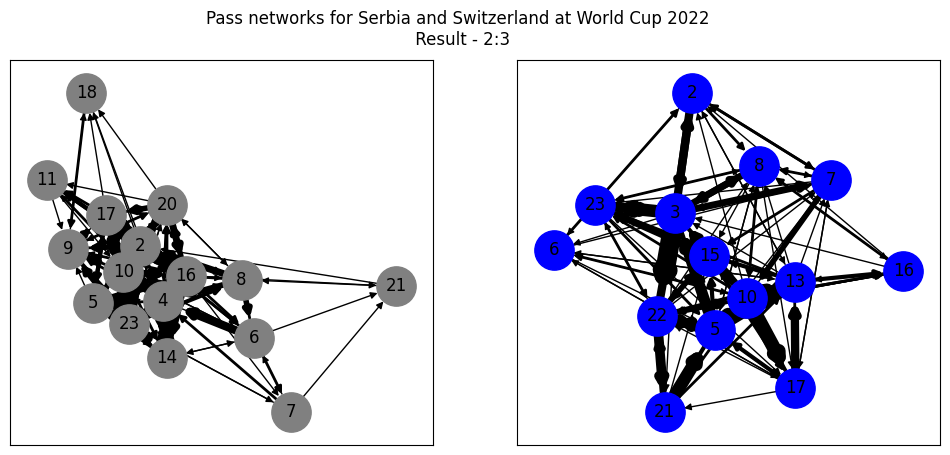

 33%|████████████████████████████                                                        | 1/3 [00:02<00:05,  2.55s/it]

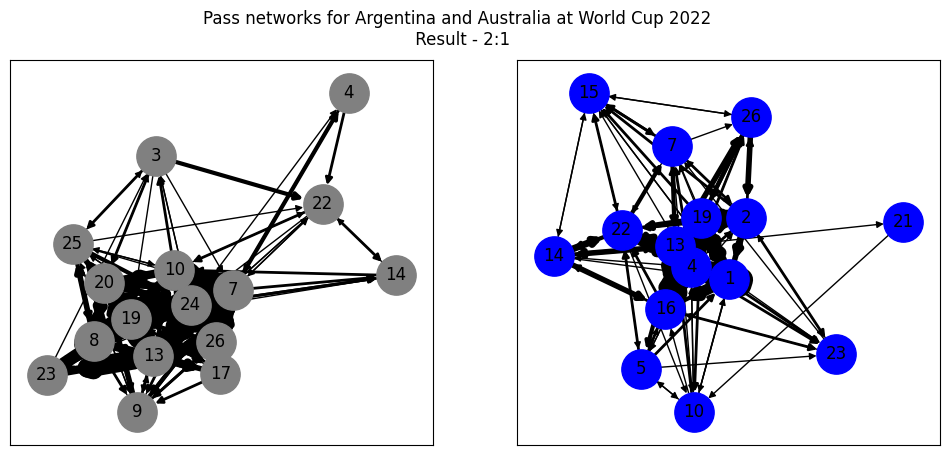

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:05<00:02,  2.57s/it]

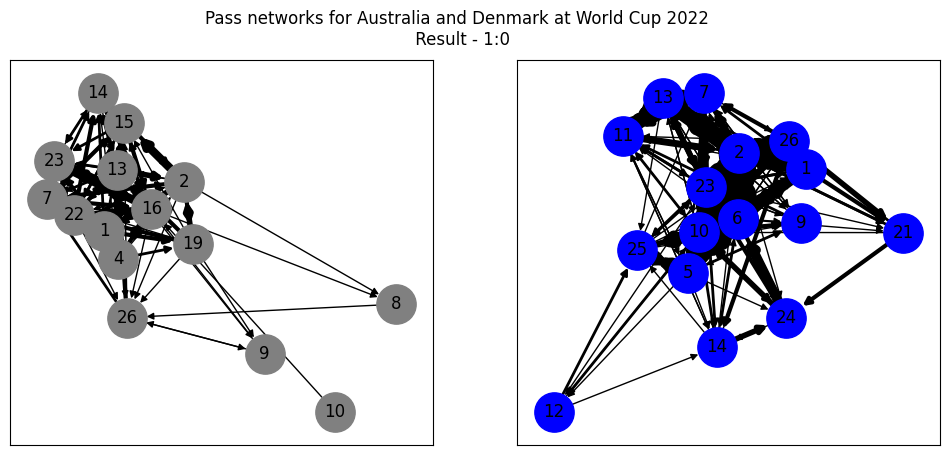

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.46s/it]


In [11]:
# Do previous analysis for all matches now
for match_id in tqdm(matches_ids[:3]):
    # Find passes for each match
    match_events = sb.events(match_id=match_id)

    team1_goals, team2_goals = int(matches[matches['match_id'] == match_id]['home_score']), int(matches[matches['match_id'] == match_id]['away_score'])
    team1, team2 = matches[matches['match_id'] == match_id]['home_team'].values[0], matches[matches['match_id'] == match_id]['away_team'].values[0]

    # We need only passing data
    match_passes = match_events[['team', 'type', 'minute', 'second', 'location', 'pass_end_location', 'pass_outcome', 'player']]

    # ------------------------------------------------------------------------------------------------------------------

    # One Match - Graphs

    # Team 1
    players_team1 = get_players_names(match_id, team1)
    passes_team1_match = get_match_passes_by_team(match_passes, team1, players_team1, team2, team_position = 0, show_pitch=False)

    # Team 2
    players_team2 = get_players_names(match_id, team2)
    passes_team2_match = get_match_passes_by_team(match_passes, team2, players_team2, team1, team_position = 1, show_pitch=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Get Graph for Team 1 at One Match
    G_team1_match = create_graph(passes_team1_match)

    edges = G_team1_match.edges()
    weights = [G_team1_match[u][v]['weight'] for u, v in edges]

    # Plot Graph
    nx.draw_networkx(G_team1_match, node_size=800, with_labels=True, node_color='gray', width = weights, ax=ax1)

    # ----------------------------------------------------------------------------------------------------

    # Get Graph for Team 2 at One Match
    G_team2_match = create_graph(passes_team2_match)

    edges = G_team2_match.edges()
    weights = [G_team2_match[u][v]['weight'] for u, v in edges]

    # Plot Graph
    nx.draw_networkx(G_team2_match, node_size=800, with_labels=True, node_color='blue', width = weights, ax=ax2)

    plt.suptitle(f"Pass networks for {team1} and {team2} at World Cup 2022 \n Result - {team1_goals}:{team2_goals}")
    plt.show()

In [12]:
from analytic_functions import find_pattern, graphs_g_b, pass_lengths, pass_seq, seconds_played, shot_seq 

In [53]:
#All the functions can be run for any match by just changing team and match_id 

team = 'Australia'
match_id = match_id
match_events = sb.events(match_id=match_id)
player_jersy = get_players_names(match_id, team)

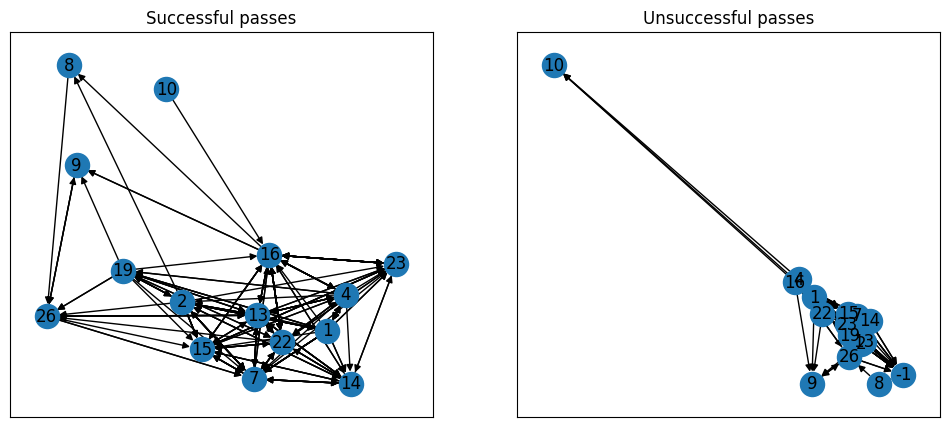

In [54]:
G_sucs, G_unsucs = graphs_g_b(match_events, player_jersy, team)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
#G_unsucs.remove_node(-1) #If we want to remove passes going to out or that were not specified for a player
nx.draw_networkx(G_sucs,ax = ax1)
nx.draw_networkx(G_unsucs,ax = ax2)

ax1.set_title('Successful passes')
ax2.set_title('Unsuccessful passes')

plt.show()

In [55]:
def plot_gscore(score, ax, xlabel, ylabel):
    player = []
    value = []
    
    for i in score:
        player.append(i[0])
        value.append(i[1])
        
    x_pos = np.arange(len(value))
    
    ax.bar(x_pos, value)
    ax.set_xticks(x_pos, player)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

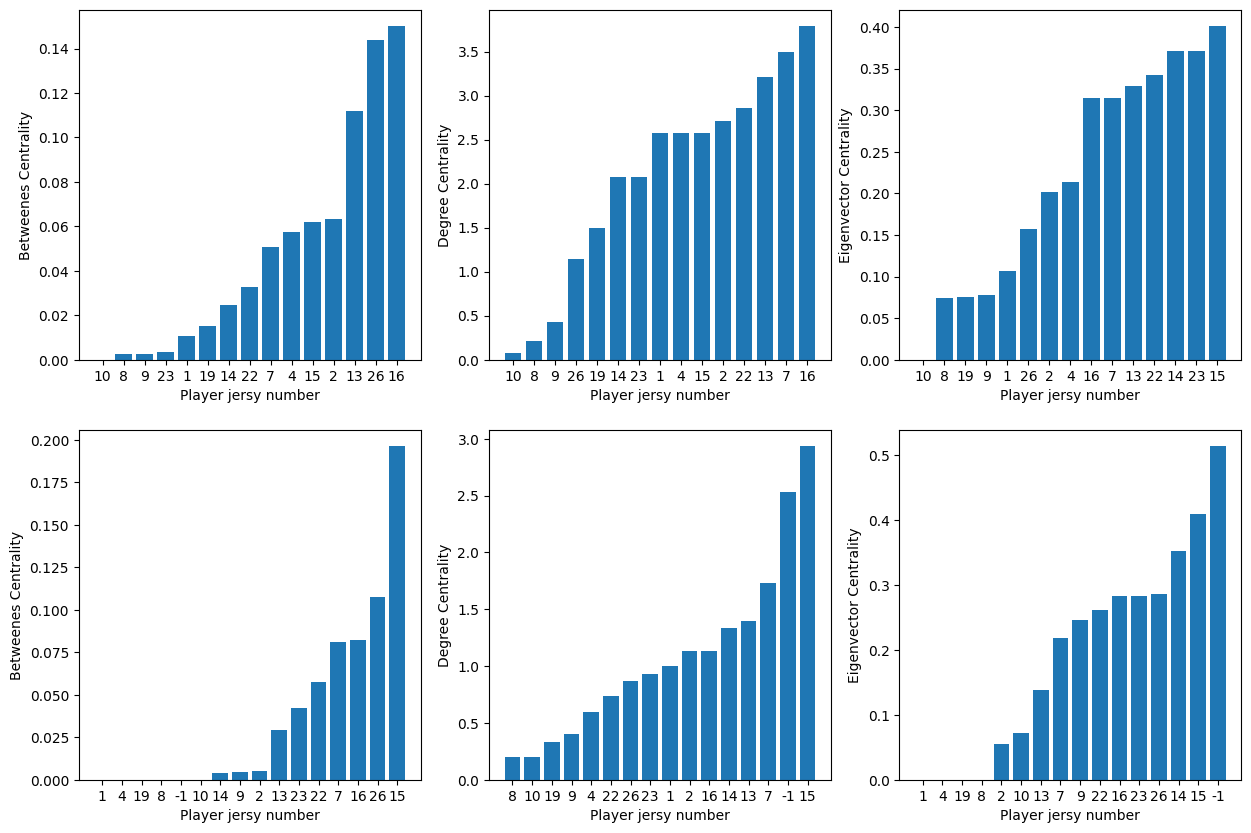

In [56]:
#Plot centrality measures on both the graphs (With successful passes and unsuccessful ones)

BC_sucs = sorted((nx.betweenness_centrality(G_sucs).items()),key = lambda x: x[1])
DC_sucs = sorted((nx.degree_centrality(G_sucs).items()),key = lambda x: x[1])
EVC_sucs = sorted((nx.eigenvector_centrality(nx.DiGraph(G_sucs)).items()),key = lambda x: x[1])

BC_unsucs = sorted((nx.betweenness_centrality(G_unsucs).items()),key = lambda x: x[1])
DC_unsucs = sorted((nx.degree_centrality(G_unsucs).items()),key = lambda x: x[1])
EVC_unsucs = sorted((nx.eigenvector_centrality(nx.DiGraph(G_unsucs)).items()),key = lambda x: x[1])

fig, ax = plt.subplots(2, 3, figsize=(15,10))

plot_gscore(BC_sucs, ax[0,0], 'Player jersy number', 'Betweenes Centrality')
plot_gscore(DC_sucs, ax[0,1], 'Player jersy number', 'Degree Centrality')
plot_gscore(EVC_sucs, ax[0,2], 'Player jersy number', 'Eigenvector Centrality')

plot_gscore(BC_unsucs, ax[1,0], 'Player jersy number', 'Betweenes Centrality')
plot_gscore(DC_unsucs, ax[1,1], 'Player jersy number', 'Degree Centrality')
plot_gscore(EVC_unsucs, ax[1,2], 'Player jersy number', 'Eigenvector Centrality')

plt.show()

In [57]:
succes_passes = G_sucs.out_degree()
unsucces_passes = G_unsucs.out_degree()

In [58]:
#Calculate the number of passes per minute per player 
#We are multiplying with 60 because the number we recive from the function is seconds

sec_played = seconds_played(match_events,team)
pass_min = []

for player in sec_played:
    no_passes = succes_passes[player_jersy[player]]
    pass_min.append((player_jersy[player],no_passes/sec_played[player]*60))
    
pass_min = sorted(pass_min, key = lambda x: x[1])

In [59]:
#Pass accuracy that we calculate as
# suc - number of successful passes
# unsuc - number of unsuccessful passes
# pass accuracy = suc/(suc+unsuc)

pass_acc = []

for player, unsuc in unsucces_passes:

    if player == -1:
        continue
    suc = succes_passes[player]
    pass_acc.append((player,suc/(suc+unsuc)))

pass_acc = sorted(pass_acc, key = lambda x: x[1])

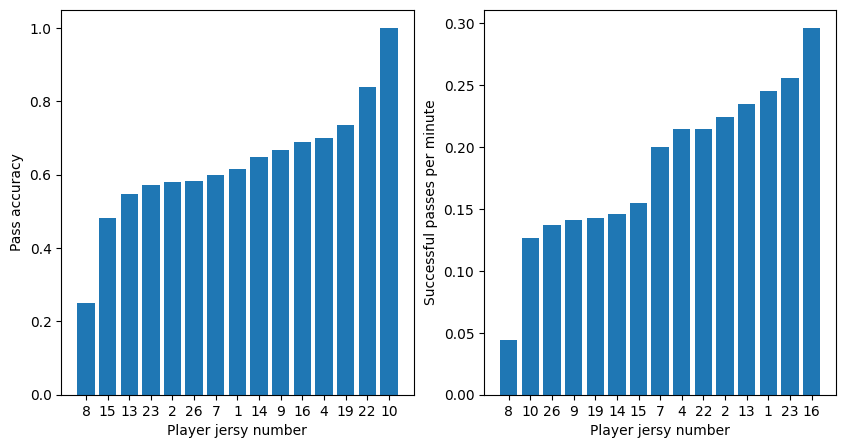

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plot_gscore(pass_acc, ax[0], 'Player jersy number', 'Pass accuracy')
plot_gscore(pass_min, ax[1], 'Player jersy number', 'Successful passes per minute')
plt.show()

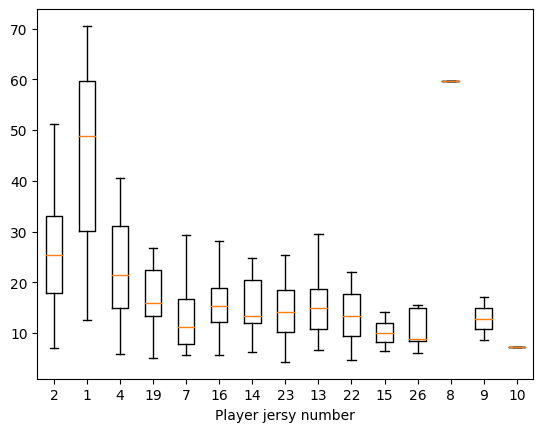

In [61]:
pass_len = pass_lengths(match_events,team)

players = []
lengths = []

for pl in pass_len:
    players.append(str(player_jersy[pl]))
    lengths.append(pass_len[pl])
    
x_pos = np.arange(len(players))

plt.boxplot(lengths, positions=x_pos,showfliers=False)
plt.xticks(x_pos,players)
plt.xlabel('Player jersy number')
plt.show()



In [62]:
#G_unsucs.remove_node(-1) #remove the node that represents out and passes to no one

#community detection for both the graphs
communities_succs = nx.community.louvain_communities(G_sucs)
communities_unsuccs = nx.community.louvain_communities(G_unsucs)

colours = ['#FFCCCC','#E5FFCC','#CCCCFF','#CCFFFF','#C0C0C0']

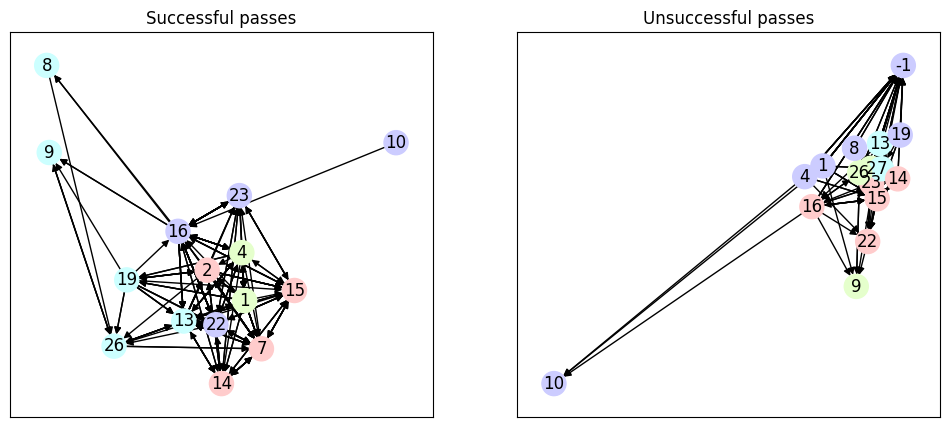

In [63]:
color_map_suc = []
color_map_unsuc = []

#G_unsucs.remove_node(-1) #If we want to remove passes going to out or that were not specified for a player

#we are making colour maps for the graphs

for node in G_sucs:
    for i in range(len(communities_succs)):
        if node in communities_succs[i]:
            color_map_suc.append(colours[i])
            break
            
for node in G_unsucs:
    for i in range(len(communities_unsuccs)):
        if node in communities_unsuccs[i]:
            color_map_unsuc.append(colours[i])
            break
            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

nx.draw_networkx(G_sucs,ax = ax1,node_color = color_map_suc)
nx.draw_networkx(G_unsucs,ax = ax2,node_color = color_map_unsuc)

ax1.set_title('Successful passes')
ax2.set_title('Unsuccessful passes')

plt.show()      


In [64]:
sequence = pass_seq(match_events,team,player_jersy)

In [65]:
#Sequences that are repeated more than once during the whole match
#-1 represents a failed pass
#100 represents a shot
#101 represents a goal
find_pattern(sequence)

{3: [([16, 4, 1], 4),
  ([4, 1, -1], 4),
  ([23, 16, 4], 3),
  ([16, 23, 16], 3),
  ([16, 13, 4], 2),
  ([1, 7, 15], 2)],
 4: [([23, 16, 4, 1], 3),
  ([16, 4, 1, -1], 3),
  ([16, 23, 16, 4], 2),
  ([16, 22, 16, 22], 2)],
 5: [([16, 23, 16, 4, 1], 2), ([23, 16, 4, 1, -1], 2)],
 6: [([16, 23, 16, 4, 1, -1], 2)]}

In [66]:
#Sequences that have lead to a shot or a goal
#-1 represents a failed pass
#100 represents a shot
#101 represents a goal

shot_seq(sequence)

[[1, 7, 15, 100],
 [22, 14, 16, 23, 14, 23, 16, 22, 100],
 [14, 2, 13, 2, 1, 14, 13, 23, 100],
 [7, 22, 14, 100],
 [19, 15, 22, 14, 101]]